In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import concurrent.futures
import os

In [9]:
# Non-parallel K-means implementation
def kmeans_non_parallel(X, k, max_iter=300):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iter):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        for i in range(k):
            centroids[i] = X[labels == i].mean(axis=0)
    return centroids, labels

In [10]:
# Parallel assignment function with concurrent.futures
def parallel_assignment_future(X_chunk, centroids):
    distances = np.linalg.norm(X_chunk[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Parallel k-means using concurrent.futures
def kmeans_parallel_optimized(X, k, max_iter=300, n_jobs=None):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iter):
        chunk_size = X.shape[0] // 8
        chunks = [X[i:i + chunk_size] for i in range(0, X.shape[0], chunk_size)]
        with concurrent.futures.ThreadPoolExecutor(max_workers=n_jobs) as executor:
            results = list(executor.map(lambda chunk: parallel_assignment_future(chunk, centroids), chunks))
        labels = np.concatenate(results)
        for i in range(k):
            centroids[i] = X[labels == i].mean(axis=0)
    return centroids, labels

In [ ]:
# Generate synthetic data for benchmarking
def generate_synthetic_data(n_samples=70000, n_features=10, n_clusters=3):
    X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=1.0, random_state=42)
    return X

# Benchmark K-means and calculate speedup
def benchmark_kmeans_with_speedup(X, n_clusters, n_jobs_list):
    non_parallel_times = []
    parallel_times = []
    speedups = []

    # Non-parallel benchmark
    start = time.time()
    centroids, labels = kmeans_non_parallel(X, n_clusters)  # non-parallel version
    end = time.time()
    non_parallel_time = end - start
    print(f"Non-parallel K-means took {non_parallel_time:.2f} seconds")

    # Parallel benchmarks with different numbers of jobs
    for n_jobs in n_jobs_list:
        start = time.time()
        centroids, labels = kmeans_parallel_optimized(X, n_clusters, n_jobs=n_jobs)  # parallel version
        end = time.time()
        parallel_time = end - start
        parallel_times.append(parallel_time)
        
        # Calculate speedup
        speedup = non_parallel_time / parallel_time
        speedups.append(speedup)
        print(f"Parallel K-means with {n_jobs} jobs took {parallel_time:.2f} seconds, Speedup: {speedup:.2f}")
    
    return non_parallel_time, parallel_times, speedups

# Generate synthetic dataset (Gaussian)
X_gaussian = generate_synthetic_data(n_samples=70000, n_features=10, n_clusters=3)
print(f"Generated Gaussian dataset with shape: {X_gaussian.shape}")

# Generate synthetic random dataset (higher dimensions)
X_random = np.random.randn(70000, 100)
print(f"Generated random dataset with shape: {X_random.shape}")

Generated Gaussian dataset with shape: (70000, 10)
Generated random dataset with shape: (70000, 100)

Benchmarking on Gaussian Dataset:
Non-parallel K-means took 8.39 seconds
Parallel K-means with 1 jobs took 8.90 seconds, Speedup: 0.94
Parallel K-means with 2 jobs took 6.39 seconds, Speedup: 1.31
Parallel K-means with 3 jobs took 5.19 seconds, Speedup: 1.62


C:\Users\louay\AppData\Local\Temp\ipykernel_7232\957195688.py:33: RuntimeWarning: Mean of empty slice.
  centroids[i] = X[labels == i].mean(axis=0)


Parallel K-means with 4 jobs took 4.26 seconds, Speedup: 1.97
Parallel K-means with 6 jobs took 5.16 seconds, Speedup: 1.62
Parallel K-means with 8 jobs took 5.38 seconds, Speedup: 1.56
Parallel K-means with 12 jobs took 5.56 seconds, Speedup: 1.51

Benchmarking on Random Dataset:
Non-parallel K-means took 94.44 seconds
Parallel K-means with 1 jobs took 88.33 seconds, Speedup: 1.07
Parallel K-means with 2 jobs took 56.14 seconds, Speedup: 1.68
Parallel K-means with 3 jobs took 48.37 seconds, Speedup: 1.95
Parallel K-means with 4 jobs took 43.22 seconds, Speedup: 2.19
Parallel K-means with 6 jobs took 42.47 seconds, Speedup: 2.22
Parallel K-means with 8 jobs took 45.11 seconds, Speedup: 2.09
Parallel K-means with 12 jobs took 27.97 seconds, Speedup: 3.38


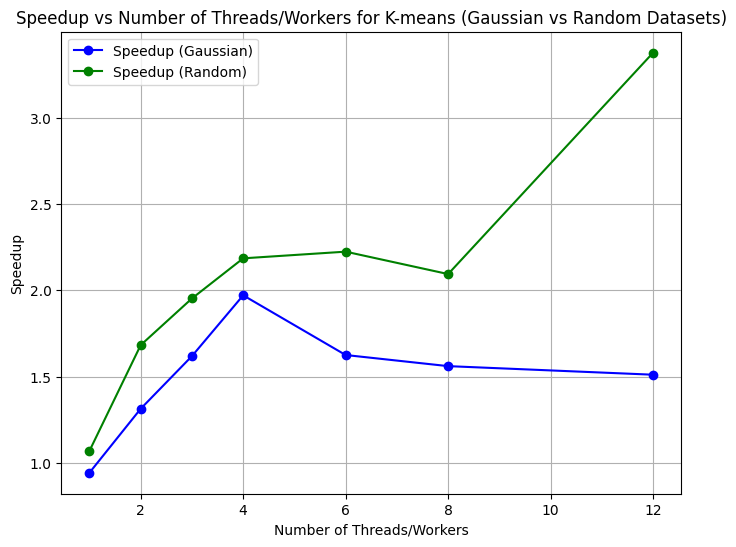

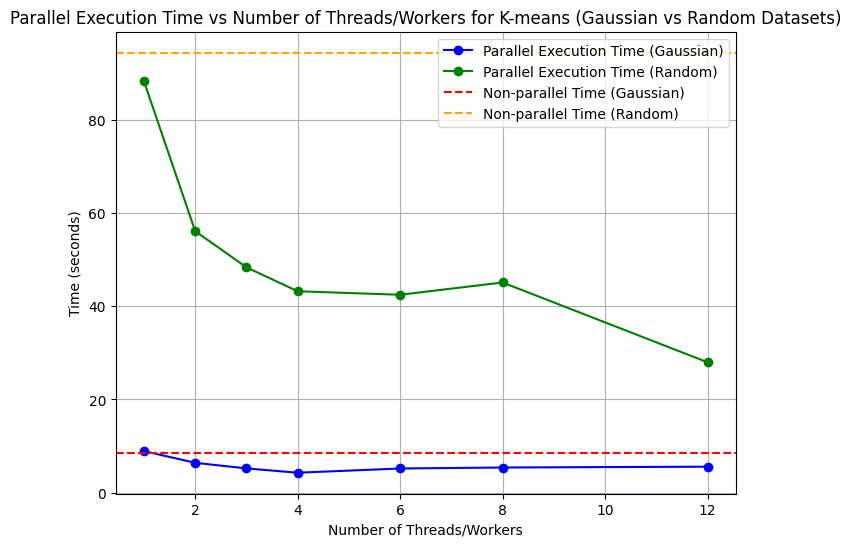

In [13]:
# Define different numbers of threads/processes for benchmarking
n_jobs_list = [1, 2, 3, 4, 6, 8, 12]

# Benchmark and calculate speedup on Gaussian dataset
print("\nBenchmarking on Gaussian Dataset:")
non_parallel_time_gaussian, parallel_times_gaussian, speedups_gaussian = benchmark_kmeans_with_speedup(X_gaussian, n_clusters=3, n_jobs_list=n_jobs_list)

# Benchmark and calculate speedup on Random dataset
print("\nBenchmarking on Random Dataset:")
non_parallel_time_random, parallel_times_random, speedups_random = benchmark_kmeans_with_speedup(X_random, n_clusters=5, n_jobs_list=n_jobs_list)

# Plot speedup vs number of threads for both datasets
plt.figure(figsize=(8, 6))
plt.plot(n_jobs_list, speedups_gaussian, marker='o', color='b', linestyle='-', label='Speedup (Gaussian)')
plt.plot(n_jobs_list, speedups_random, marker='o', color='g', linestyle='-', label='Speedup (Random)')
plt.xlabel('Number of Threads/Workers')
plt.ylabel('Speedup')
plt.title('Speedup vs Number of Threads/Workers for K-means (Gaussian vs Random Datasets)')
plt.grid(True)
plt.legend()
plt.show()

# Plot parallel execution times vs number of threads for both datasets
plt.figure(figsize=(8, 6))
plt.plot(n_jobs_list, parallel_times_gaussian, marker='o', color='b', linestyle='-', label='Parallel Execution Time (Gaussian)')
plt.plot(n_jobs_list, parallel_times_random, marker='o', color='g', linestyle='-', label='Parallel Execution Time (Random)')
plt.axhline(y=non_parallel_time_gaussian, color='r', linestyle='--', label='Non-parallel Time (Gaussian)')
plt.axhline(y=non_parallel_time_random, color='orange', linestyle='--', label='Non-parallel Time (Random)')
plt.xlabel('Number of Threads/Workers')
plt.ylabel('Time (seconds)')
plt.title('Parallel Execution Time vs Number of Threads/Workers for K-means (Gaussian vs Random Datasets)')
plt.grid(True)
plt.legend()
plt.show()
